In [13]:
from datetime import datetime, date
import math
import os
import warnings

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

from utils import int_to_binary_str, compute_solution, compute_fidelity


pd.set_option('display.max_columns', None)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
DEFAULT_ANGLE = 1.047

experiment_names = os.listdir('experiments/results')
experiment_names = [name for name in experiment_names if not name.startswith('test')]
experiment_results = []

for experiment in experiment_names:

    experiment_result_files = os.listdir(f'experiments/results/{experiment}')
    
    for result_file in experiment_result_files:
        result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f').date()
        result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
        #result['experiment'] = experiment
        result['date'] = result_date
        experiment_results.append(result)


experiment_results = pd.concat(experiment_results)
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['optimizer'] = experiment_results['config'].apply(lambda c: c.get('optimizer'))
experiment_results['problem_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('problem_hamiltonian'))
experiment_results['cost_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('cost_hamiltonian'))
experiment_results['gamma_0'] = experiment_results['config'].apply(lambda c: c.get('initial_gamma'))
experiment_results['beta_0'] = experiment_results['config'].apply(lambda c: c.get('initial_beta'))
experiment_results['experiment'] = experiment_results['config'].apply(lambda c: c.get('experiment'))
experiment_results['extended_qaoa'] = experiment_results['config'].apply(lambda c: c.get('extended_qaoa', False))
experiment_results['max_layers'] = experiment_results['config'].apply(lambda c: c.get('layers'))
experiment_results['commit_date'] = pd.to_datetime(experiment_results['config'].apply(lambda c: c.get('commit_date')))
experiment_results['setup'] = experiment_results['experiment'].str.split('_').str[1:].str.join('_')
experiment_results['state_populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['state_populations'], row['solution']), axis=1)
experiment_results['gamma_0'] = experiment_results['gamma_0'].round(3)
experiment_results['beta_0'] = experiment_results['beta_0'].round(3)
experiment_results['angle_interpolation'] = experiment_results['commit_date'] >= datetime(2025,6,10)

In [15]:
dup_subset = ['experiment', 'layers', 'optimizer', 'gamma_0', 'beta_0', 'cost', 'angle_interpolation']

dups = experiment_results[dup_subset]
dups = dups.groupby(dups.columns.tolist(),as_index=False).size().sort_values('size', ascending=False)
dups = dups[dups['size']>1]

if not dups.empty:
    print('Duplicates found!')
    display(dups.head())

experiment_results = experiment_results.drop_duplicates(subset=dup_subset).reset_index(drop=True)

Duplicates found!


,experiment,layers,optimizer,gamma_0,beta_0,cost,angle_interpolation,size
2565,N39_standard,2,BFGS,1.047,1.047,470.251191,False,3
2550,N39_standard,1,BFGS,1.047,1.047,522.271063,False,3
2092,N35_standard,9,BFGS,1.047,1.047,113.135852,False,3
2077,N35_standard,8,BFGS,1.047,1.047,175.273769,False,3
2062,N35_standard,7,BFGS,1.047,1.047,201.743376,False,3


In [16]:
plot_colors = [
    #[Dark ,    light]
    ["black",   "#A0A0A0"],  # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#006633", "#CCFFCC"],  # Green
    ["#cc4c02", "#fe9929"],  # Orange
    ["#91003f", "#c994c7"],  # Purple
    ["#8c510a", "#d8b365"],  # Brown
    ["#0868ac", "#43a2ca"],  # Cian
    ["#b8860b", "#ffd700"],  # Golden
]

In [17]:
Ns = sorted(experiment_results.N.unique())
optimizers = sorted(experiment_results.optimizer.unique())
setups = sorted(experiment_results.setup.unique(), reverse=True)

In [18]:
group_cols = ['N', 'setup', 'optimizer', 'layers', 'extended_qaoa']

experiment_results_agg = (
    experiment_results
        .groupby(group_cols)
        .agg({
            'num_qubits': 'first',
            'N': 'count',
            'cost': ['mean', 'median', 'std', 'max', 'min'],
            'fidelity': ['mean', 'median', 'std', 'max', 'min'],
            'optimizer_time': ['mean', 'median', 'std', 'max', 'min'],
            'state_populations': lambda x: np.sum(x.tolist(), axis=0).tolist()
        })
    )

experiment_results_agg.columns = ['_'.join(map(str, col)) for col in experiment_results_agg.columns.to_flat_index()]
experiment_results_agg = experiment_results_agg.rename(columns={'num_qubits_first': 'num_qubits'})
experiment_results_agg = experiment_results_agg.rename(columns={'state_populations_<lambda>': 'populations'})
experiment_results_agg = experiment_results_agg.rename(columns={'N_count': 'count'})

experiment_results_agg['populations_mean'] = experiment_results_agg.apply(lambda row: np.array(row['populations'])/row['count'], axis=1)
experiment_results_agg = experiment_results_agg.drop(columns='populations')

# Get the id where cost is minimum for each group
idx_min = experiment_results.groupby(group_cols)['cost'].idxmin()
best_populations = experiment_results.loc[idx_min, group_cols + ['state_populations']]
best_populations = best_populations.rename(columns={'state_populations': 'best_populations'})

# Merge the best_id into the aggregated DataFrame
experiment_results_agg = experiment_results_agg.merge(best_populations, on=group_cols, how='left')


experiment_results_agg = experiment_results_agg.sort_values(['N', 'optimizer', 'setup', 'layers', 'extended_qaoa'])
experiment_results_agg = experiment_results_agg.reset_index(drop=True)

# experiment_results_agg['infidelity_mean'] = 1 - experiment_results_agg['fidelity_mean']
# experiment_results_agg['infidelity_median'] = 1 - experiment_results_agg['fidelity_median']
# experiment_results_agg['infidelity_min'] = 1 - experiment_results_agg['fidelity_max']
# experiment_results_agg['infidelity_max'] = 1 - experiment_results_agg['fidelity_min']

# experiments_df = pd.merge(experiment_configs, experiment_results_agg, how='inner', on='experiment')

# if (experiments_df['num_gates_std'] != 0).any():
#     print('Warning: There are experiments with inconsistent number of gates')

## Comparison between optimizers

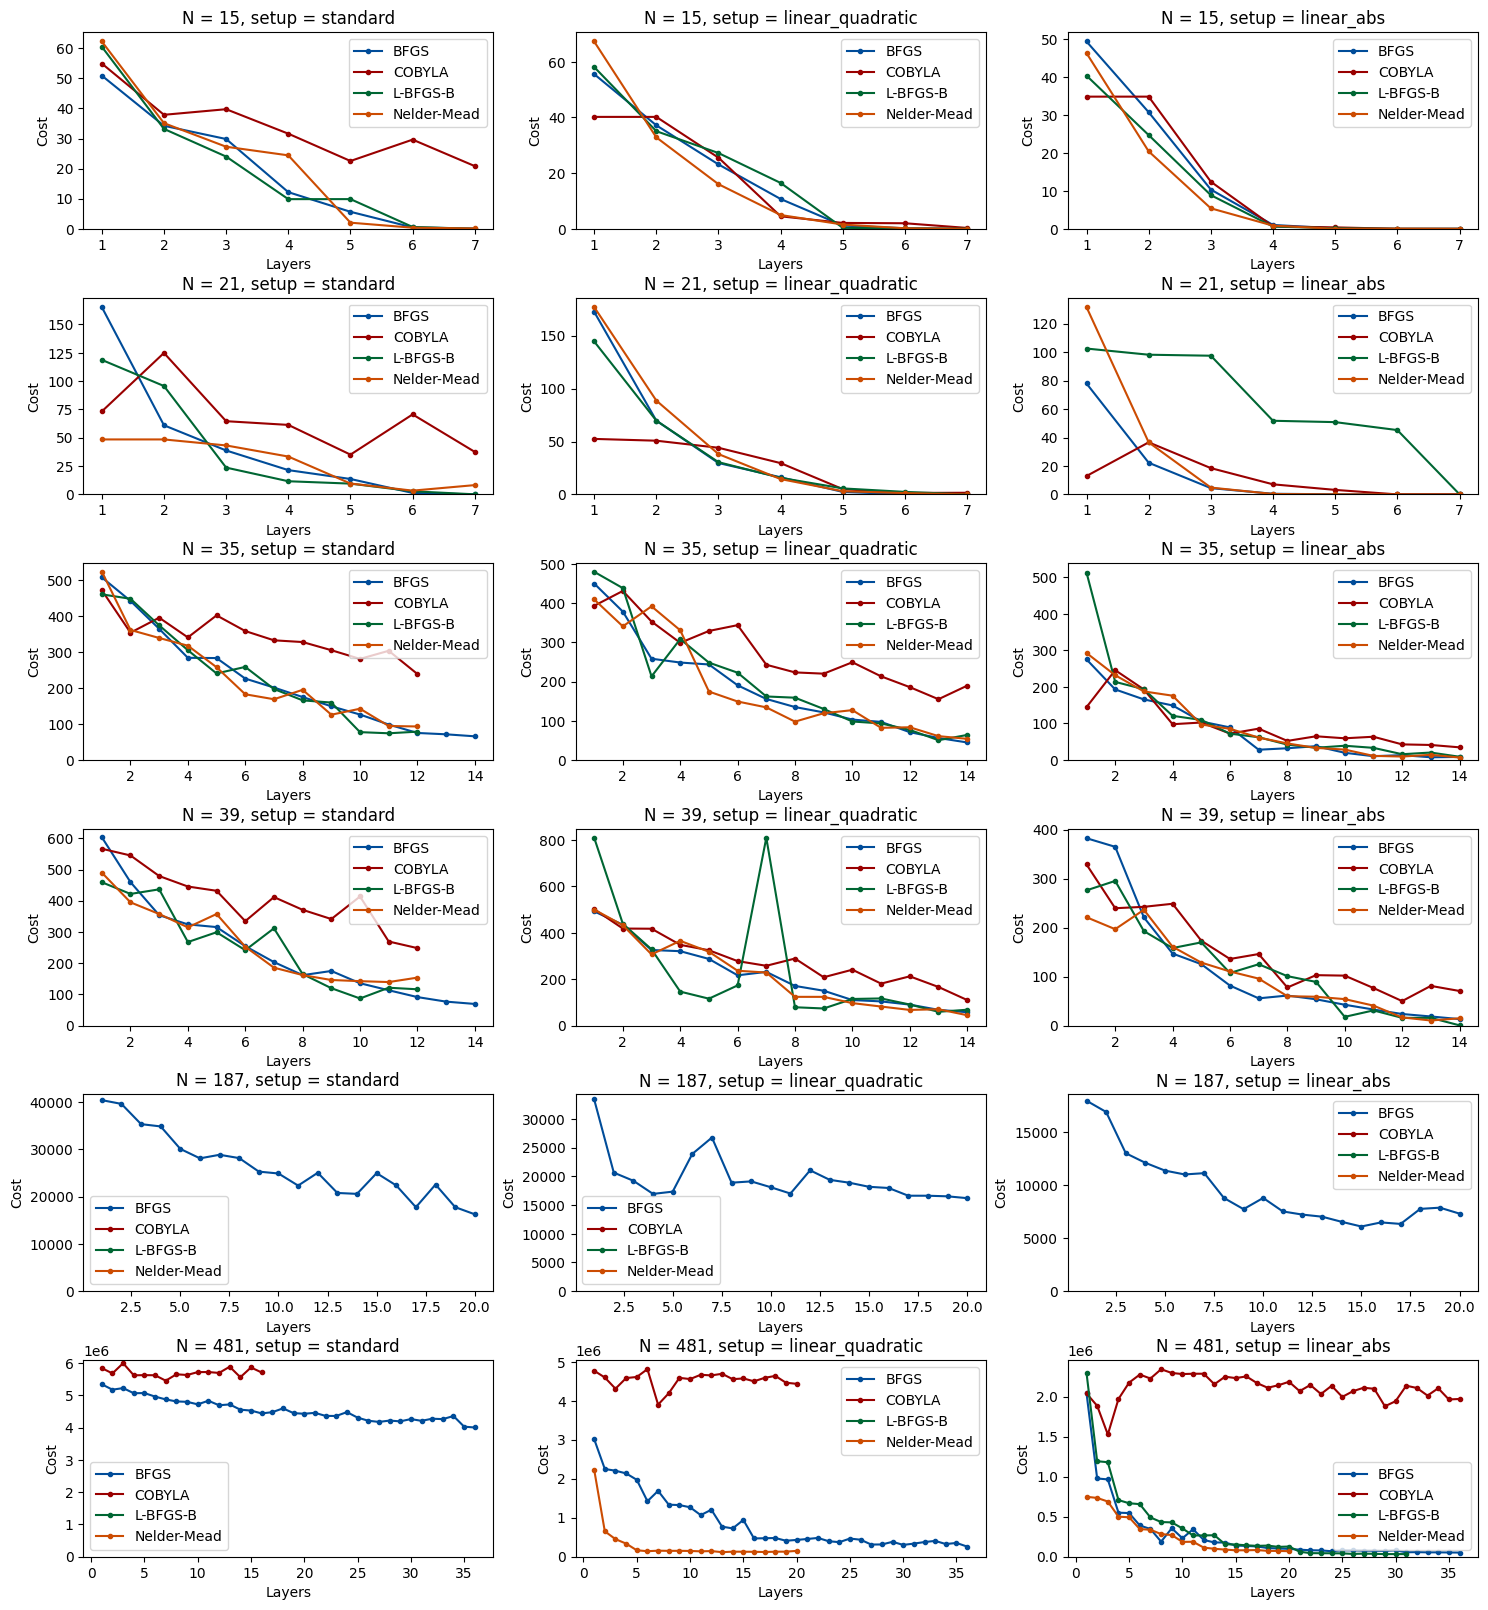

In [7]:
extended_qaoa = False

fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N) & (experiment_results_agg.extended_qaoa == extended_qaoa)]
    for k, setup in enumerate(setups):
        for j, optimizer in enumerate(optimizers):
            df = df_N[(df_N.setup == setup) & (df_N.optimizer == optimizer)].copy()
            if setup == 'linear_abs':
                df['cost_median'] = np.power(df['cost_median'], 2)
            axs[i,k].plot('layers', 'cost_median', data=df, marker='.', color=plot_colors[j+1][0], label=optimizer)

        axs[i,k].set_ylabel('Cost')
        axs[i,k].set_title(f'N = {N}, setup = {setup}')
        axs[i,k].set_xlabel('Layers');
        axs[i,k].set_ylim(0);

        axs[i,k].legend(loc='best');

fig_name = f'plots/methods_comparison.pdf'
plt.savefig(fig_name, bbox_inches='tight')


We use BFGS since it is the fastest optimizer for this dimensionalities

## Comparison between setups for BFGS

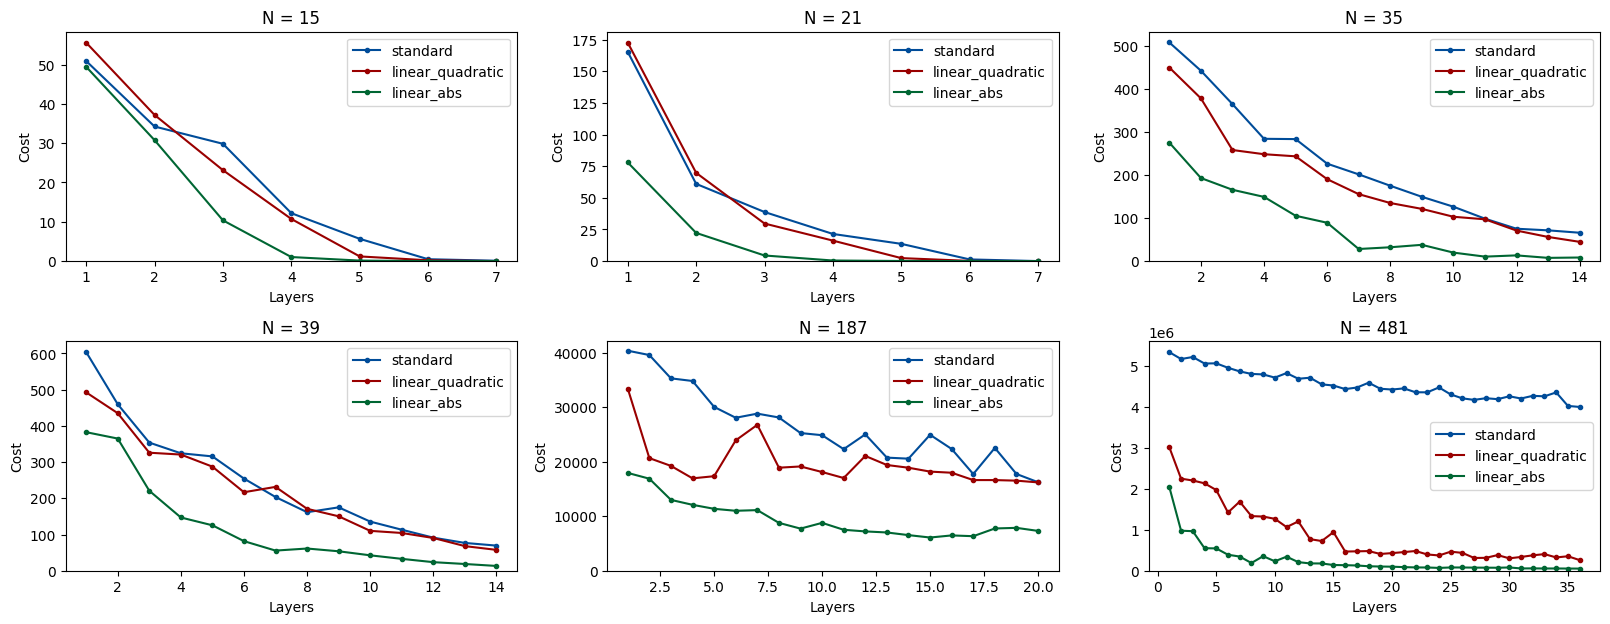

In [8]:
extended_qaoa = False

fig, axs = plt.subplots(math.ceil(len(Ns)/3), 3, figsize=(3.3*len(Ns), 7))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

axs = axs.flatten()

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N) & (experiment_results_agg.optimizer == 'BFGS') & (experiment_results_agg.extended_qaoa == extended_qaoa)]
    for j, setup in enumerate(setups):
        df = df_N[df_N.setup == setup].copy()
        if setup == 'linear_abs':
            df['cost_median'] = np.power(df['cost_median'], 2)
        axs[i].plot('layers', 'cost_median', data=df, marker='.', color=plot_colors[j+1][0], label=setup)

    axs[i].set_ylabel('Cost')
    axs[i].set_title(f'N = {N}')
    axs[i].set_xlabel('Layers');
    axs[i].set_ylim(0);

    axs[i].legend(loc='best');

fig_name = f'plots/setups_comparison.pdf'
plt.savefig(fig_name, bbox_inches='tight')


## Comparison between traditional vs extended QAOA

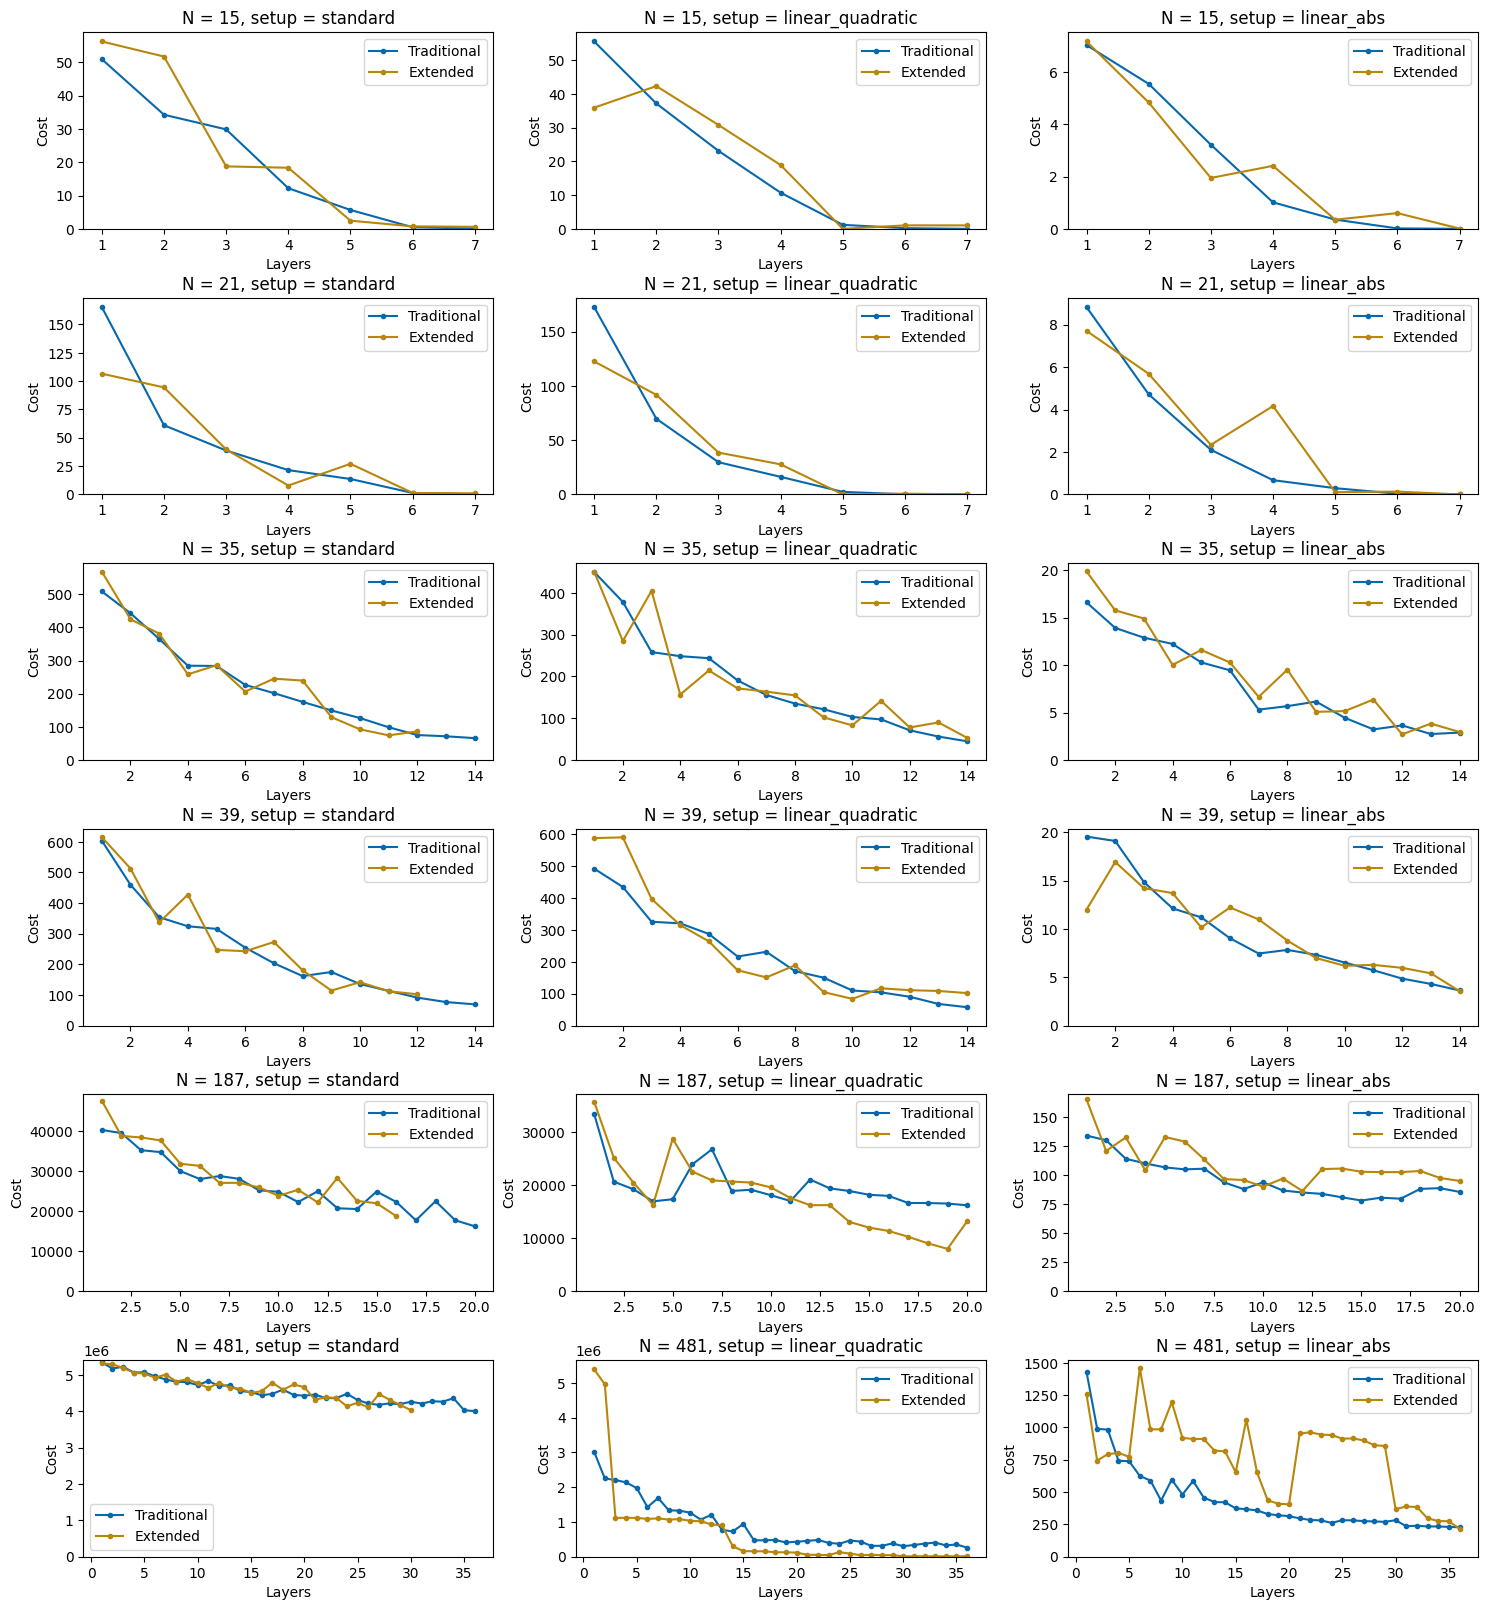

In [9]:
fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N) & (experiment_results_agg.optimizer == 'BFGS')]

    for j, setup in enumerate(setups):

        df = df_N[df_N['setup']==setup]

        axs[i,j].plot('layers', 'cost_median', data=df[df['extended_qaoa']==False], marker='.', color=plot_colors[7][0], label='Traditional')
        axs[i,j].plot('layers', 'cost_median', data=df[df['extended_qaoa']==True], marker='.', color=plot_colors[8][0], label='Extended')

        axs[i,j].set_ylabel('Cost')
        axs[i,j].set_title(f'N = {N}, setup = {setup}')
        axs[i,j].set_xlabel('Layers');
        axs[i,j].set_ylim(0);

        axs[i,j].legend(loc='best');


## Populations

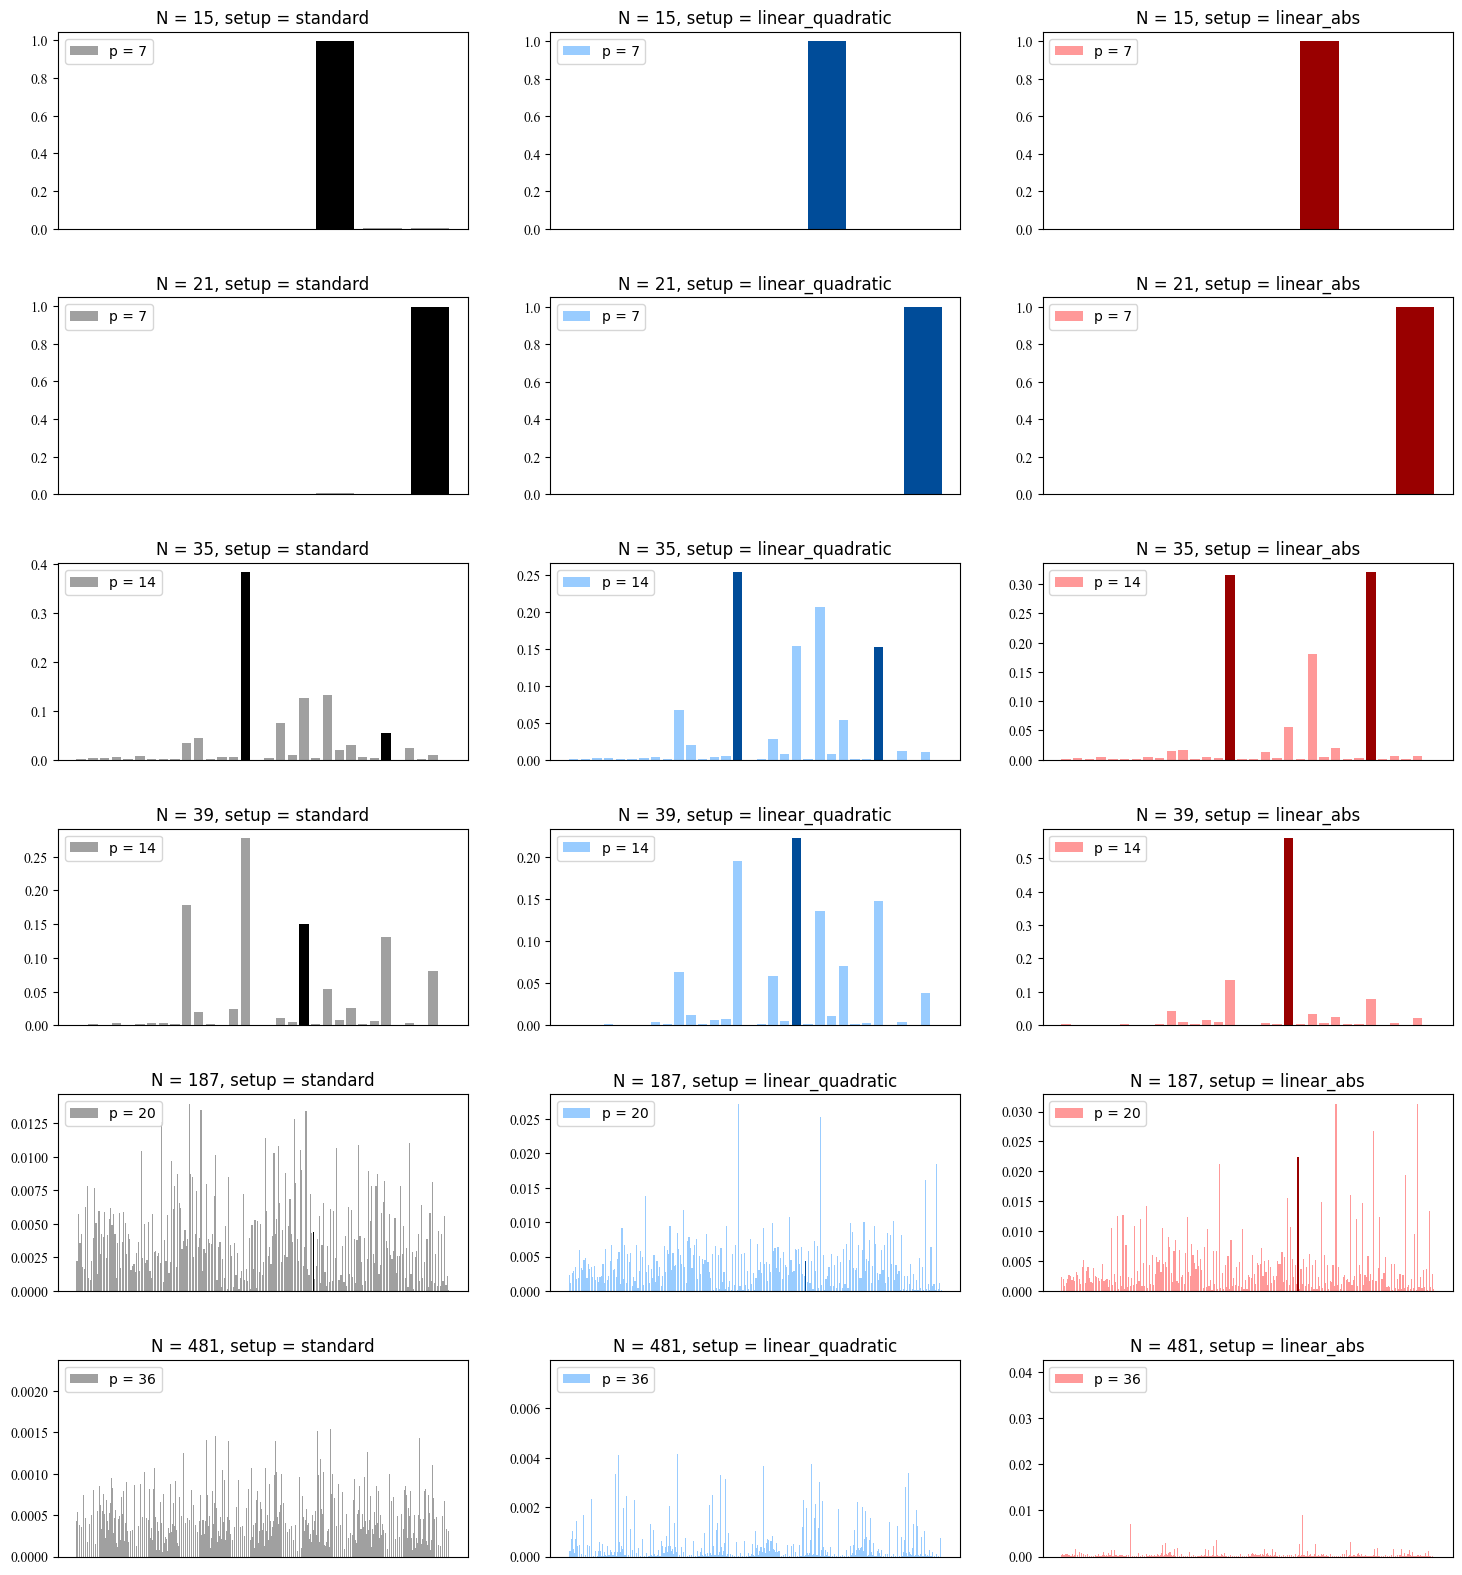

In [10]:
fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[(experiment_results_agg.N == N) & (experiment_results_agg.optimizer == 'BFGS')
                                  & (experiment_results_agg.extended_qaoa == False)].reset_index(drop=True)
    num_qubits = df_N.loc[0, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    max_layers = df_N['layers'].max()

    for j, setup in enumerate(setups):

        df_N_setup = df_N[(df_N['setup']==setup)]
        max_layers = df_N_setup['layers'].max()
        df =  df_N_setup[df_N_setup['layers']==max_layers].reset_index(drop=True).loc[0, 'populations_mean']

        bar_colors = [plot_colors[j][0] if c in solutions else plot_colors[j][1] for c in x_hist]

        axs[i][j].bar(x_hist, df, label=f'p = {max_layers}', color=bar_colors)
        axs[i][j].set_ylim(0)

        labels = (axs[i][j].get_xticklabels() + axs[i][j].get_yticklabels())

        for label in labels:
            label.set_fontname('Times New Roman')

        axs[i][j].legend(loc='upper left')
        axs[i][j].set_xticks(range(2**num_qubits), "")
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].set_title(f'N = {N}, setup = {setup}')

fig_name = f'plots/analysis_populations.pdf'
plt.savefig(fig_name, bbox_inches='tight')

## Angle interpolation

In [20]:
#experiment_results = experiment_results[(experiment_results['gamma_0']==DEFAULT_ANGLE) & (experiment_results['beta_0']==DEFAULT_ANGLE)]

group_cols = ['N', 'setup', 'optimizer', 'layers', 'extended_qaoa', 'angle_interpolation']

experiment_results_agg = (
    experiment_results
        .groupby(group_cols)
        .agg({
            'num_qubits': 'first',
            'N': 'count',
            'cost': ['mean', 'median', 'std', 'max', 'min'],
            'fidelity': ['mean', 'median', 'std', 'max', 'min'],
            'optimizer_time': ['mean', 'median', 'std', 'max', 'min'],
            'state_populations': lambda x: np.sum(x.tolist(), axis=0).tolist()
        })
    )

experiment_results_agg.columns = ['_'.join(map(str, col)) for col in experiment_results_agg.columns.to_flat_index()]
experiment_results_agg = experiment_results_agg.rename(columns={'num_qubits_first': 'num_qubits'})
experiment_results_agg = experiment_results_agg.rename(columns={'state_populations_<lambda>': 'populations'})
experiment_results_agg = experiment_results_agg.rename(columns={'N_count': 'count'})

experiment_results_agg['populations_mean'] = experiment_results_agg.apply(lambda row: np.array(row['populations'])/row['count'], axis=1)
experiment_results_agg = experiment_results_agg.drop(columns='populations')

# Get the id where cost is minimum for each group
idx_min = experiment_results.groupby(group_cols)['cost'].idxmin()
best_populations = experiment_results.loc[idx_min, group_cols + ['state_populations']]
best_populations = best_populations.rename(columns={'state_populations': 'best_populations'})

# Merge the best_id into the aggregated DataFrame
experiment_results_agg = experiment_results_agg.merge(best_populations, on=group_cols, how='left')


experiment_results_agg = experiment_results_agg.sort_values(['N', 'optimizer', 'setup', 'layers', 'extended_qaoa'])
experiment_results_agg = experiment_results_agg.reset_index(drop=True)

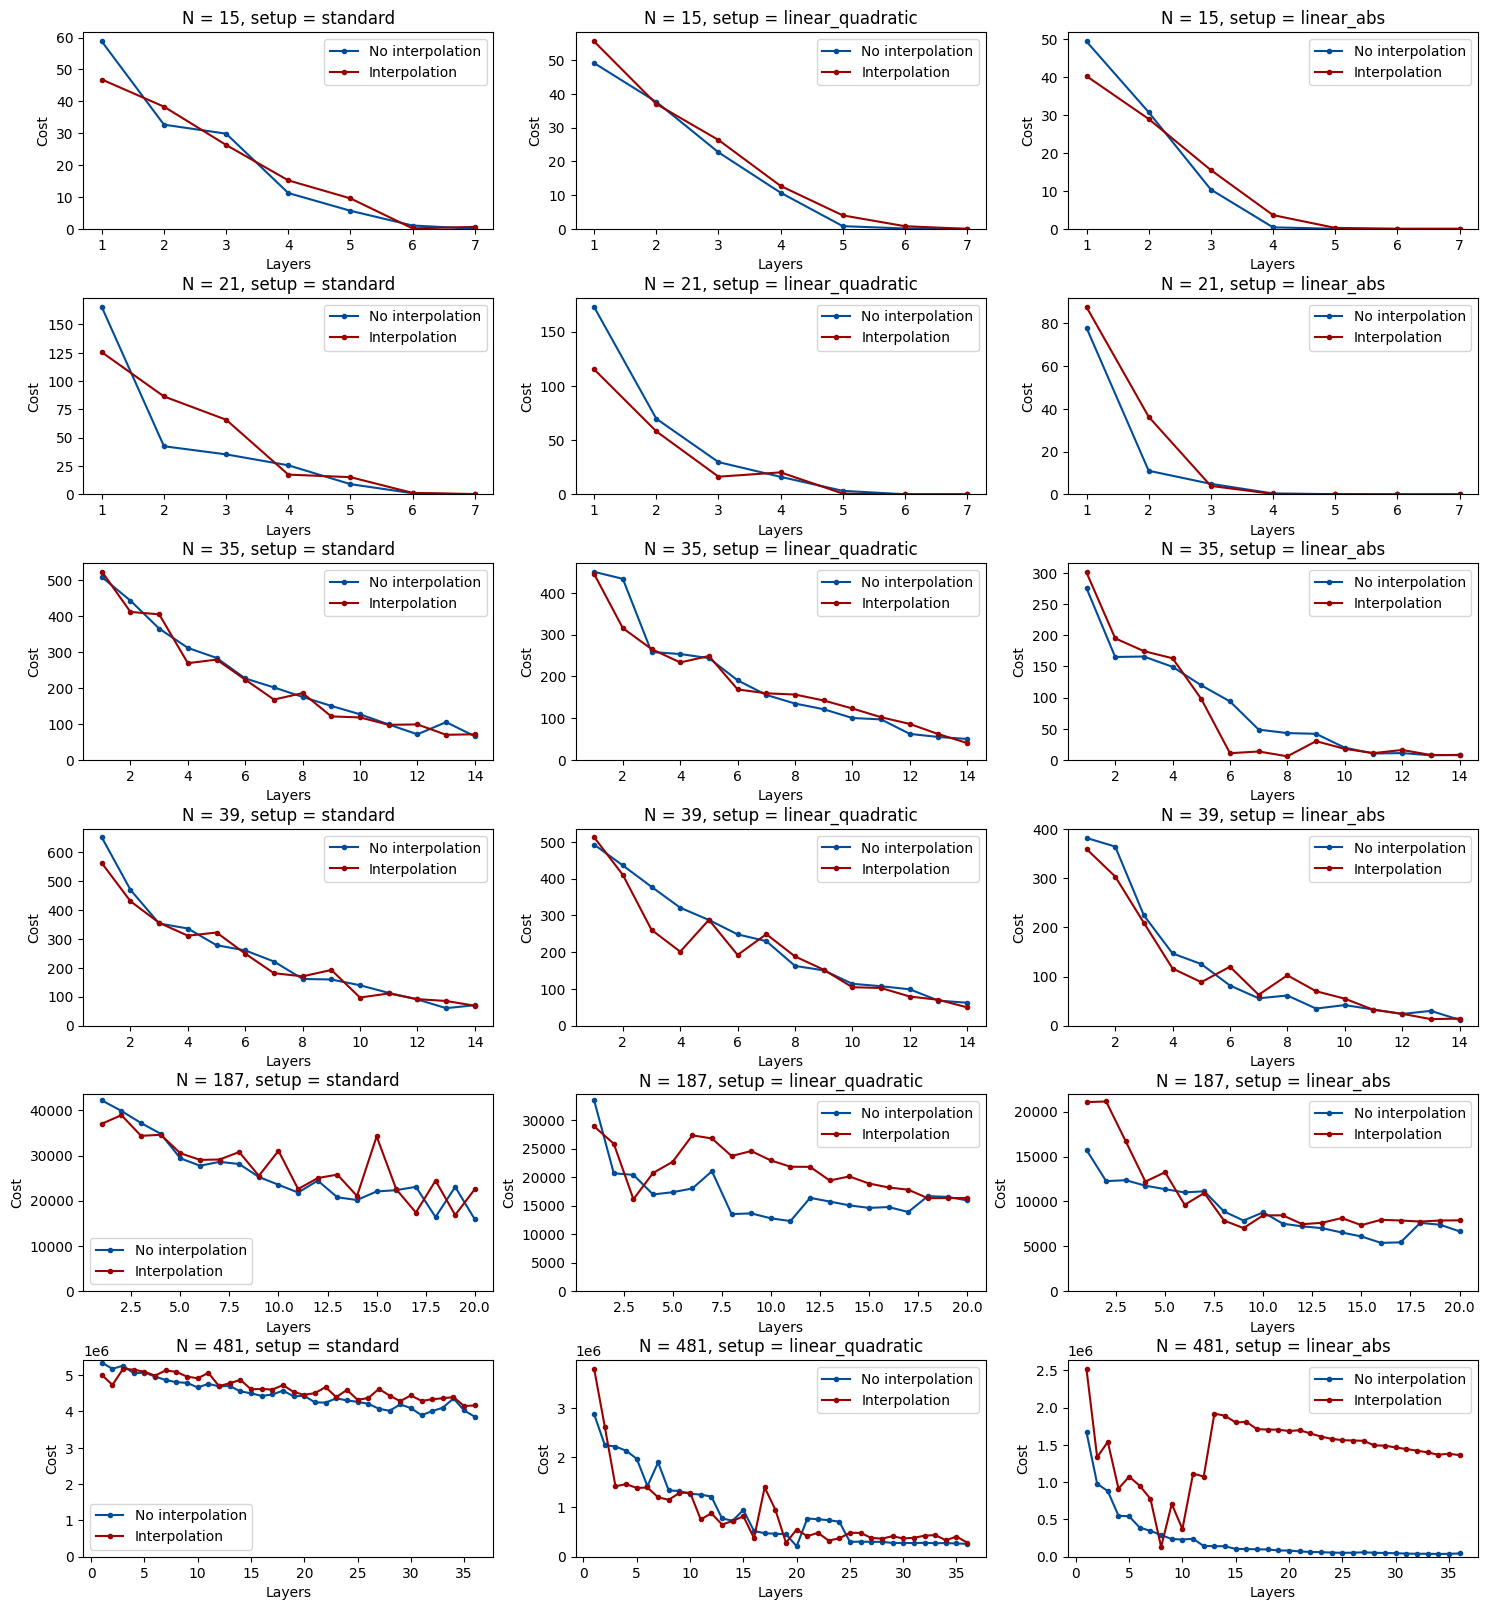

In [ ]:
extended_qaoa = False
optimizer = 'BFGS'

fig, axs = plt.subplots(len(Ns), len(setups), figsize=(6*len(setups), 3.3*len(Ns)))
fig.subplots_adjust(hspace=0.35, wspace=0.2)

for i, N in enumerate(Ns):
    df_N = experiment_results_agg[
        (experiment_results_agg.N == N)
        & (experiment_results_agg.extended_qaoa == extended_qaoa)
        & (experiment_results_agg.optimizer == optimizer)]
    for k, setup in enumerate(setups):
        for j, interpolation in enumerate([False, True]):
            label = 'Interpolation' if interpolation else 'No interpolation'
            df = df_N[(df_N.setup == setup) & (df_N.angle_interpolation == interpolation)].copy()
            if setup == 'linear_abs':
                df['cost_median'] = np.power(df['cost_median'], 2)
            axs[i,k].plot('layers', 'cost_median', data=df, marker='.', color=plot_colors[j+1][0], label=label)

        axs[i,k].set_ylabel('Cost')
        axs[i,k].set_title(f'N = {N}, setup = {setup}')
        axs[i,k].set_xlabel('Layers');
        axs[i,k].set_ylim(0);

        axs[i,k].legend(loc='best');

fig_name = f'plots/interpolation.pdf'
plt.savefig(fig_name, bbox_inches='tight')